# Neutronics CALPHAD Results Analysis

This notebook provides detailed analysis of the R2S (Rigorous 2-Step) simulation results for different elements.

## Contents:
1. **Data Loading & Overview** - Load HDF5 results and examine structure
2. **Dose Rate Analysis** - Compare dose rates across elements and times
3. **Gas Production Analysis** - Examine helium and hydrogen production
4. **Reference Comparisons** - Compare with literature values
5. **Individual Element Deep Dive** - Detailed analysis per element
6. **Diagnostics & Troubleshooting** - Identify potential issues


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
import seaborn as sns
from IPython.display import display, HTML

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (10, 6)

print("📊 Neutronics CALPHAD Analysis Notebook")
print("="*50)


📊 Neutronics CALPHAD Analysis Notebook


## 1. Data Loading & Overview


In [3]:
# Configuration
ELMS = ['V', 'Cr', 'Ti', 'W', 'Zr']
TIMES = np.array([1, 3600, 24*3600, 14*24*3600, 365*24*3600, 5*365*24*3600, 7*365*24*3600, 100*365*24*3600])
TIME_LABELS = ['1s', '1h', '1d', '14d', '1y', '5y', '7y', '100y']
results_dir = "elem_lib"

# Load all results
results = {}
missing_files = []

print("Loading results files...")
for element in ELMS:
    h5_file = os.path.join(results_dir, element, f"{element}.h5")
    if os.path.exists(h5_file):
        with h5py.File(h5_file, 'r') as f:
            results[element] = {
                'dose_times': f['dose_times'][:],
                'dose': f['dose'][:],
                'gases': {key.split('/')[-1]: f[key][()] for key in f.keys() if key.startswith('gas/')}
            }
        print(f"✅ {element}: {len(results[element]['dose'])} time points")
    else:
        missing_files.append(element)
        print(f"❌ {element}: File not found at {h5_file}")

if missing_files:
    print(f"\n⚠️  Missing results for: {missing_files}")
    print("Run 'neutronics-calphad build-library' first.")
else:
    print("\n✅ All element results loaded successfully!")


Loading results files...
✅ V: 8 time points
✅ Cr: 8 time points
✅ Ti: 8 time points
✅ W: 8 time points
✅ Zr: 8 time points

✅ All element results loaded successfully!


In [4]:
# Create summary DataFrame
summary_data = []
for element in results.keys():
    data = results[element]
    summary_data.append({
        'Element': element,
        'Time Points': len(data['dose']),
        'Max Dose (µSv/h)': np.max(data['dose']) if len(data['dose']) > 0 else 0,
        'Min Dose (µSv/h)': np.min(data['dose']) if len(data['dose']) > 0 else 0,
        'He3 (atoms)': data['gases'].get('He3', 0),
        'He4 (atoms)': data['gases'].get('He4', 0),
        'Total He (atoms)': data['gases'].get('He3', 0) + data['gases'].get('He4', 0),
        'Total H (atoms)': sum(data['gases'].get(h, 0) for h in ['H1', 'H2', 'H3'])
    })

summary_df = pd.DataFrame(summary_data)
print("📋 Results Summary:")
display(summary_df)


📋 Results Summary:


,Element,Time Points,Max Dose (µSv/h),Min Dose (µSv/h),He3 (atoms),He4 (atoms),Total He (atoms),Total H (atoms)
0,V,8,1.081448e-08,0.000000e+00,0,0,0,0
1,Cr,8,7.048232e-09,1.086120e-11,0,0,0,0
2,Ti,8,1.335625e-08,9.308864e-09,0,0,0,0
3,W,8,2.630689e-09,5.330947e-10,0,0,0,0
4,Zr,8,8.036768e-09,5.360292e-09,0,0,0,0


## 2. Dose Rate Analysis


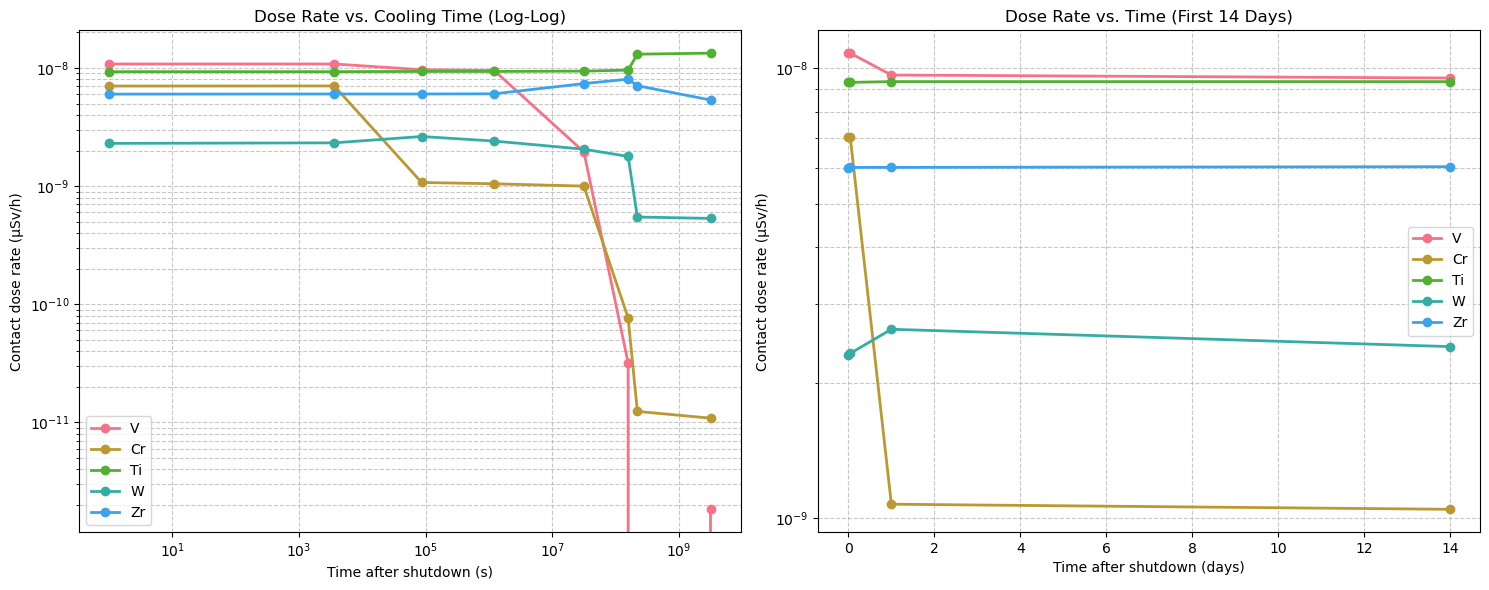

In [5]:
# Plot dose rates vs time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Log-log plot
for element in results.keys():
    data = results[element]
    if len(data['dose']) > 0:
        ax1.loglog(data['dose_times'], data['dose'], 'o-', label=element, linewidth=2, markersize=6)

ax1.set_xlabel("Time after shutdown (s)")
ax1.set_ylabel("Contact dose rate (µSv/h)")
ax1.set_title("Dose Rate vs. Cooling Time (Log-Log)")
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.7)

# Linear plot for recent times
for element in results.keys():
    data = results[element]
    if len(data['dose']) > 0:
        # Only plot first 4 time points (up to 14 days)
        times_days = data['dose_times'][:4] / (24*3600)
        doses = data['dose'][:4]
        ax2.semilogy(times_days, doses, 'o-', label=element, linewidth=2, markersize=6)

ax2.set_xlabel("Time after shutdown (days)")
ax2.set_ylabel("Contact dose rate (µSv/h)")
ax2.set_title("Dose Rate vs. Time (First 14 Days)")
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [6]:
# Reference comparison function
def get_reference_ranges():
    """Literature reference ranges for fusion material activation"""
    reference_data = {
        'V': {
            1: (1e6, 1e8), 3600: (1e5, 1e7), 24*3600: (1e4, 1e6), 14*24*3600: (1e2, 1e4),
            365*24*3600: (10, 1e3), 5*365*24*3600: (1, 100), 7*365*24*3600: (0.1, 10), 100*365*24*3600: (0.01, 1)
        },
        'Cr': {
            1: (1e5, 1e7), 3600: (1e4, 1e6), 24*3600: (1e3, 1e5), 14*24*3600: (1e1, 1e3),
            365*24*3600: (1, 100), 5*365*24*3600: (0.1, 10), 7*365*24*3600: (0.01, 1), 100*365*24*3600: (0.001, 0.1)
        }
    }
    return reference_data

# Compare with references
reference_data = get_reference_ranges()
comparison_data = []

for element in results.keys():
    if element in reference_data:
        data = results[element]
        for i, (time, dose) in enumerate(zip(data['dose_times'], data['dose'])):
            if time in reference_data[element]:
                ref_low, ref_high = reference_data[element][time]
                status = "Within Range"
                if dose < ref_low:
                    status = f"Too Low ({ref_low/dose:.1e}x)" if dose > 0 else "Too Low (inf)"
                elif dose > ref_high:
                    status = f"Too High ({dose/ref_high:.1e}x)"
                
                comparison_data.append({
                    'Element': element,
                    'Time': TIME_LABELS[i] if i < len(TIME_LABELS) else f"{time}s",
                    'Calculated (µSv/h)': f"{dose:.2e}",
                    'Reference Low': f"{ref_low:.2e}",
                    'Reference High': f"{ref_high:.2e}",
                    'Status': status
                })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("🔍 Reference Comparison:")
    display(comparison_df)
else:
    print("No reference data available for loaded elements.")


🔍 Reference Comparison:


,Element,Time,Calculated (µSv/h),Reference Low,Reference High,Status
0,V,1s,1.08e-08,1.00e+06,1.00e+08,Too Low (9.2e+13x)
1,V,1h,1.08e-08,1.00e+05,1.00e+07,Too Low (9.2e+12x)
2,V,1d,9.67e-09,1.00e+04,1.00e+06,Too Low (1.0e+12x)
3,V,14d,9.52e-09,1.00e+02,1.00e+04,Too Low (1.1e+10x)
4,V,1y,1.95e-09,1.00e+01,1.00e+03,Too Low (5.1e+09x)
5,V,5y,3.20e-11,1.00e+00,1.00e+02,Too Low (3.1e+10x)
6,V,7y,0.00e+00,1.00e-01,1.00e+01,Too Low (inf)
7,V,100y,1.84e-12,1.00e-02,1.00e+00,Too Low (5.4e+09x)
8,Cr,1s,7.03e-09,1.00e+05,1.00e+07,Too Low (1.4e+13x)
9,Cr,1h,7.05e-09,1.00e+04,1.00e+06,Too Low (1.4e+12x)


## 3. Gas Production Analysis


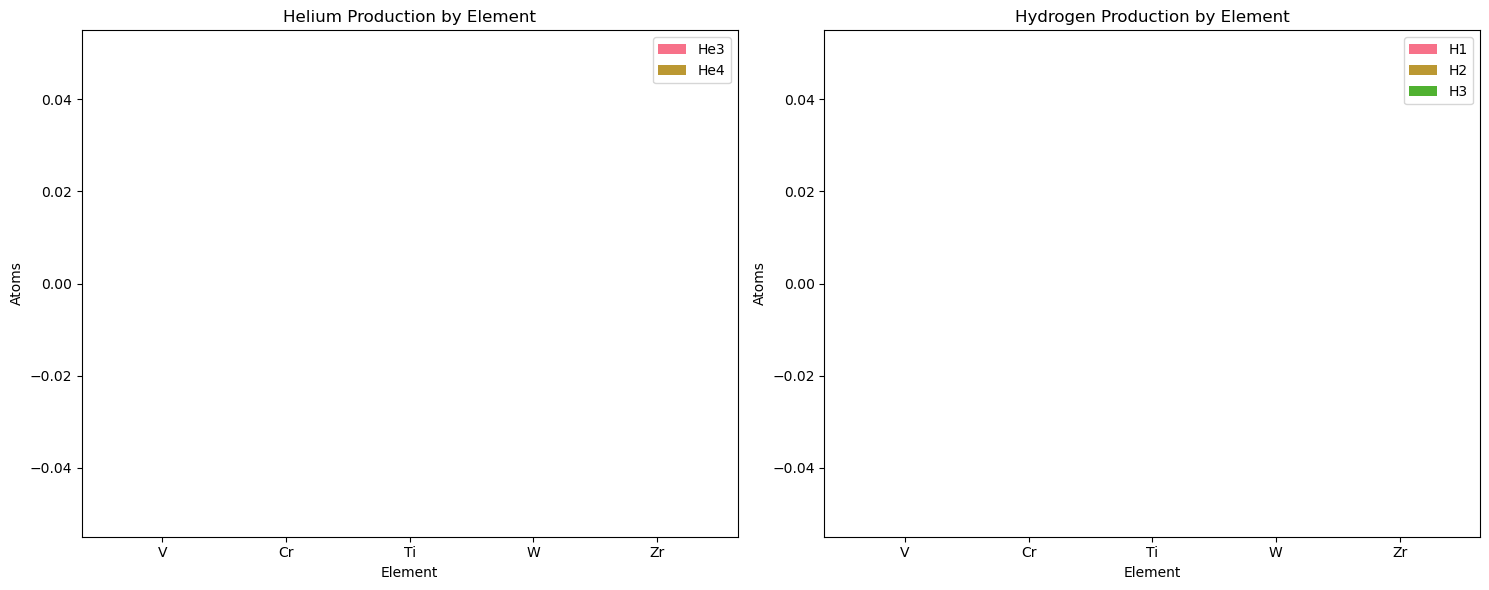

💨 Gas Production Summary:


,Element,He3,He4,H1,H2,H3,Total He,Total H
0,V,0,0,0,0,0,0,0
1,Cr,0,0,0,0,0,0,0
2,Ti,0,0,0,0,0,0,0
3,W,0,0,0,0,0,0,0
4,Zr,0,0,0,0,0,0,0


In [7]:
# Gas production comparison
gas_data = []
for element in results.keys():
    gases = results[element]['gases']
    gas_data.append({
        'Element': element,
        'He3': gases.get('He3', 0),
        'He4': gases.get('He4', 0),
        'H1': gases.get('H1', 0),
        'H2': gases.get('H2', 0),
        'H3': gases.get('H3', 0),
        'Total He': gases.get('He3', 0) + gases.get('He4', 0),
        'Total H': sum(gases.get(h, 0) for h in ['H1', 'H2', 'H3'])
    })

gas_df = pd.DataFrame(gas_data)

# Plot gas production
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Helium production
he_data = gas_df[['Element', 'He3', 'He4', 'Total He']].set_index('Element')
he_data[['He3', 'He4']].plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Helium Production by Element')
ax1.set_ylabel('Atoms')
ax1.set_xlabel('Element')
ax1.legend()
ax1.tick_params(axis='x', rotation=0)

# Hydrogen production
h_data = gas_df[['Element', 'H1', 'H2', 'H3']].set_index('Element')
h_data.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Hydrogen Production by Element')
ax2.set_ylabel('Atoms')
ax2.set_xlabel('Element')
ax2.legend()
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("💨 Gas Production Summary:")
display(gas_df)


## 4. Diagnostics & Troubleshooting


In [8]:
# Diagnostic checks
print("🔧 Diagnostic Analysis")
print("="*30)

# Check for common issues
issues_found = []

for element in results.keys():
    data = results[element]
    
    # Check 1: All zero doses
    if all(d == 0 for d in data['dose']):
        issues_found.append(f"{element}: All dose rates are zero")
    
    # Check 2: Extremely low doses
    if max(data['dose']) < 1e-10:
        issues_found.append(f"{element}: Extremely low dose rates (max: {max(data['dose']):.2e})")
    
    # Check 3: No gas production
    total_gas = sum(data['gases'].values())
    if total_gas == 0:
        issues_found.append(f"{element}: No gas production detected")
    
    # Check 4: Unrealistic dose evolution
    doses = np.array(data['dose'])
    if len(doses) > 1 and not all(doses[:-1] >= doses[1:]):
        issues_found.append(f"{element}: Dose rates not monotonically decreasing")
    
    # Check 5: Missing time points
    if len(data['dose']) != len(TIMES):
        issues_found.append(f"{element}: Missing time points ({len(data['dose'])}/{len(TIMES)})")

if issues_found:
    print("⚠️  Issues Detected:")
    for issue in issues_found:
        print(f"  • {issue}")
else:
    print("✅ No obvious issues detected")

# Performance metrics
print("\n📈 Performance Metrics:")
for element in results.keys():
    data = results[element]
    if len(data['dose']) >= 4:
        ratio_14d_to_1s = data['dose'][3] / data['dose'][0] if data['dose'][0] > 0 else 0
        print(f"{element}: 14d/1s dose ratio = {ratio_14d_to_1s:.2e}")

# File system check
print("\n💾 File System Status:")
for element in ELMS:
    elem_dir = os.path.join(results_dir, element)
    if os.path.exists(elem_dir):
        files = os.listdir(elem_dir)
        h5_exists = f"{element}.h5" in files
        depletion_exists = "depletion" in files
        photon_dirs = [f for f in files if f.startswith("photons_time_")]
        print(f"{element}: H5✅ Depletion{'✅' if depletion_exists else '❌'} Photon_dirs:{len(photon_dirs)}")
    else:
        print(f"{element}: Directory missing")


🔧 Diagnostic Analysis
⚠️  Issues Detected:
  • V: No gas production detected
  • V: Dose rates not monotonically decreasing
  • Cr: No gas production detected
  • Cr: Dose rates not monotonically decreasing
  • Ti: No gas production detected
  • Ti: Dose rates not monotonically decreasing
  • W: No gas production detected
  • W: Dose rates not monotonically decreasing
  • Zr: No gas production detected
  • Zr: Dose rates not monotonically decreasing

📈 Performance Metrics:
V: 14d/1s dose ratio = 8.81e-01
Cr: 14d/1s dose ratio = 1.49e-01
Ti: 14d/1s dose ratio = 1.00e+00
W: 14d/1s dose ratio = 1.05e+00
Zr: 14d/1s dose ratio = 1.01e+00

💾 File System Status:
V: H5✅ Depletion✅ Photon_dirs:8
Cr: H5✅ Depletion✅ Photon_dirs:8
Ti: H5✅ Depletion✅ Photon_dirs:8
W: H5✅ Depletion✅ Photon_dirs:8
Zr: H5✅ Depletion✅ Photon_dirs:8


## 5. Export Results


In [9]:
# Export comprehensive results to CSV
if results:
    # Create comprehensive export DataFrame
    export_data = []
    
    for element in results.keys():
        data = results[element]
        base_row = {'Element': element}
        
        # Add dose data
        for i, (time, label) in enumerate(zip(TIMES, TIME_LABELS)):
            if i < len(data['dose']):
                base_row[f'Dose_{label}'] = data['dose'][i]
            else:
                base_row[f'Dose_{label}'] = np.nan
        
        # Add gas data
        for gas, value in data['gases'].items():
            base_row[f'Gas_{gas}'] = value
        
        export_data.append(base_row)
    
    export_df = pd.DataFrame(export_data)
    
    # Save to CSV
    export_filename = "neutronics_analysis_results.csv"
    export_df.to_csv(export_filename, index=False)
    print(f"📁 Results exported to: {export_filename}")
    
    # Show export preview
    print("\n📋 Export Preview:")
    display(export_df.head())
else:
    print("No results to export. Run the simulation first.")


📁 Results exported to: neutronics_analysis_results.csv

📋 Export Preview:


,Element,Dose_1s,Dose_1h,Dose_1d,Dose_14d,Dose_1y,Dose_5y,Dose_7y,Dose_100y
0,V,1.081190e-08,1.081448e-08,9.668613e-09,9.521155e-09,1.949635e-09,3.196183e-11,0.000000e+00,1.837703e-12
1,Cr,7.034401e-09,7.048232e-09,1.074189e-09,1.046502e-09,1.000563e-09,7.649723e-11,1.238715e-11,1.086120e-11
2,Ti,9.308864e-09,9.311896e-09,9.347087e-09,9.346266e-09,9.408235e-09,9.598356e-09,1.308986e-08,1.335625e-08
3,W,2.300912e-09,2.324689e-09,2.630689e-09,2.407177e-09,2.053820e-09,1.784199e-09,5.476621e-10,5.330947e-10
4,Zr,6.010475e-09,6.025210e-09,6.025964e-09,6.047432e-09,7.379408e-09,8.036768e-09,7.080800e-09,5.360292e-09
